In [10]:
# 生成各种阻力位分析器
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import copy
from funcs import *
import pandas as pd
import sys
from operator import itemgetter
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
import TSLPy3 as tsl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib

np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang

In [199]:
def dtes2Label(dtes):
    return np.array([datetime.datetime.strptime(str(d), '%Y%m%d').date() for d in dtes])


import matplotlib.dates as mdates


In [190]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1

In [191]:
with open('dailyBarMtx.pkl', 'rb+') as f:
    z = pickle.load(f)
dtes = z['dtes']
idx = dtes>20190101
dtes = np.array(dtes).astype(np.int)[idx]
tkrs = list(z['tkrs'])
open_mtx = z['open_mtx'][:,idx]
high_mtx = z['high_mtx'][:,idx]
low_mtx = z['low_mtx'][:,idx]
close_mtx = z['close_mtx'][:,idx]
name = z['name']
belong = z['belong']
shenwan1 = z['shenwan1']
shenwan2 = z['shenwan2']
shenwan3 = z['shenwan3']
vol_mtx = z['vol_mtx'][:,idx]
amount_mtx = z['amount_mtx'][:,idx]


In [192]:
#策略部分：
# 1.计算阻力位
# 2.计算高开破阻力位
# 3.收集交易，计算交易持仓到收盘，第二天开盘，第二天收盘的回报率。
k = 1
N = 250 # 取N个交易日的高点作为阻力位
Nl = 250 # 取Nl个交易日的高点计算分位区间
openGapMax = 0.05 # 不要高开超过若干个点的
openGapMin = 0.01 # 不要高开低于若干个点的
thresPriceLoc = 2  # 价格在历史价格区间的分位数
highVolumeThres = 0 # 前一天成交量是再前一天成交量的倍数
preHigh = np.zeros(close_mtx.shape)
preHighLong = np.zeros(close_mtx.shape)
idxOpenHigh = np.array(np.zeros(close_mtx.shape), dtype='bool')
idxPriceLoc = np.array(np.zeros(close_mtx.shape), dtype='bool')
idxHighVolume = np.array(np.zeros(close_mtx.shape), dtype='bool')
idxNotNewStock = np.array(np.zeros(close_mtx.shape), dtype='bool')
idxPreDayNotBreakHigh = np.array(np.zeros(close_mtx.shape), dtype='bool')
idxNotAllDayZhangTing = np.array(np.zeros(close_mtx.shape), dtype='bool')  #  今日未开板
idxOpenSmallerThanGapMax = np.array(np.zeros(close_mtx.shape), dtype='bool') # 今日开盘价高出preHigh在openGapMax以下
idxOpenBiggerThanGapMin = np.array(np.zeros(close_mtx.shape), dtype='bool') # 今日开盘价高出preHigh在openGapMax以下
idxNotZhangtingAtClose = np.array(np.zeros(close_mtx.shape), dtype='bool') # 今日开盘价高出preHigh在openGapMax以下
idxNotZhangtingAtAnyMoment = np.array(np.zeros(close_mtx.shape), dtype='bool') # 今日开盘价高出preHigh在openGapMax以下

idxQ = np.array(np.zeros(close_mtx.shape), dtype='bool')
for k in range(close_mtx.shape[1]-1):
    q = np.max((0, k-N))
    preHigh[:, k+1] = np.max(high_mtx[:, q:k+1], axis=1)
    q = np.max((0, k-Nl))
    preHighLong[:, k+1] = np.max(high_mtx[:, q:k+1], axis=1)
    idxPriceLoc[:, k+1] = close_mtx[:,k]/preHighLong[:, k+1]<thresPriceLoc
    idxHighVolume[:, k+1] = amount_mtx[:, k]/amount_mtx[:, k-1]>highVolumeThres
    #idxOpenHigh[:, k+1] = idxHighVolume[:, k+1] & (close_mtx[:, k] < preHigh[:, k+1]) & (open_mtx[:, k+1] > preHigh[:, k+1]) & (open_mtx[:, k+1]!=high_mtx[:, k+1]) & ((open_mtx[:, k+1]/preHigh[:,k+1]-1)<openGapMax)& ((open_mtx[:, k+1]/preHigh[:, k+1]-1)>openGapMin)  
    #idxOpenHigh[:, k+1] = ((open_mtx[:, k+1]/preHigh[:,k+1]-1)<openGapMax)& ((open_mtx[:, k+1]/preHigh[:, k+1]-1)>openGapMin)  
    idxPreDayNotBreakHigh[:, k+1] = high_mtx[:, k] < preHigh[:, k] # 昨日未创新高
    idxNotAllDayZhangTing[:, k+1] = (low_mtx[:, k+1]!=high_mtx[:, k+1])  #  今日未开板
    idxOpenSmallerThanGapMax[:, k+1] = ((open_mtx[:, k+1]/preHigh[:,k+1]-1)<openGapMax) # 今日开盘价高出preHigh在openGapMax以下
    idxOpenBiggerThanGapMin[:, k+1] = ((open_mtx[:, k+1]/preHigh[:,k+1]-1)>openGapMin) # 今日开盘价高出preHigh在openGapMax以下
    idxOpenHigh[:, k+1] = (open_mtx[:, k+1] > preHigh[:, k+1])
    idxNotZhangtingAtClose[:, k+1]= (close_mtx[:, k+1] / close_mtx[:, k] - 1)<0.05
    idxNotZhangtingAtAnyMoment[:, k+1]= (high_mtx[:, k+1] / close_mtx[:, k] - 1)<0.05
    idxNotNewStock[:, k+1] = False==np.any(open_mtx[:, np.max((0, k-90)):k+1]==0, axis=1)
idxQ = idxOpenHigh & idxNotNewStock & idxPreDayNotBreakHigh & idxNotAllDayZhangTing

C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\An

In [204]:
def calculateProfit(idxQ, title1, detail='no', off=1):
    r1 = np.zeros((len(dtes)))
    r2 = np.zeros((len(dtes)))
    r3 = np.zeros((len(dtes)))
    r4 = np.zeros((len(dtes)))
    r5 = np.zeros((len(dtes)))
    r6 = np.zeros((len(dtes)))
    r7 = np.zeros((len(dtes)))
    r8 = np.zeros((len(dtes)))
    for k in range(1,close_mtx.shape[1]):
        close_yesterday = close_mtx[idxQ[:,k], k-1]
        close_today = close_mtx[idxQ[:,k], k]
        open_today = open_mtx[idxQ[:,k], k]
        if k+1<len(dtes):
            close_tomorrow = close_mtx[idxQ[:,k], k+1]
            open_tomorrow = open_mtx[idxQ[:,k], k+1]
        else:
            close_tomorrow = close_today #如果是今天的数据，则没有明天收盘价格，采用今天收盘价
            open_tomorrow = close_today  #如果是今天的数据，则没有明天收盘价格，采用今天收盘价
        if k+2<len(dtes):
            open_2 = open_mtx[idxQ[:,k], k+2]
        else:
            open_2 = close_tomorrow  #如果是今天的数据，则没有明天收盘价格，采用今天收盘价
        if k+off<len(dtes):
            close_off = close_mtx[idxQ[:,k], k+off] 
        else:
            close_off = close_today #如果是今天的数据，则没有明天收盘价格，采用今天收盘价
        
        r1[k]=(np.mean(close_today/open_today-1))
        r2[k]=(np.mean(open_tomorrow/open_today-1))
        r3[k]=(np.mean(open_2/open_tomorrow-1))
        r4[k]=(np.mean(close_off/close_today-1))
        r5[k]=(np.mean(close_off/open_tomorrow-1))
        r6[k]=(np.mean(close_tomorrow/close_today-1))
        r7[k]=(np.mean(open_tomorrow/close_today-1))
        intradayHigh = high_mtx[idxQ[:,k], k]
        idxZhangTing = high_mtx[idxQ[:,k], k]/close_yesterday-1 > 0.095
        t = name[idxQ[:,k]]
        cbuy = close_today.copy()
        cbuy[idxZhangTing] = intradayHigh[idxZhangTing]
        r8[k]=(np.mean(close_off/cbuy-1))
        if (np.isfinite(r5[-1])) & (detail=='yes'):
            print(str(dtes[k])+'共交易'+str(len(t))+' 平均利润:'+str(np.round(r5[-1]*1e4)/1e2)+'%, 分笔交易:')
            for i in range(len(t)):
                print(t[i], 
                      dtes[k],
                      '盘中涨停？',str(idxZhangTing[i]),
                      '买入价:', np.round(cbuy[i], 2),
                      '收盘：',
                      np.round(close_today[i],2), 
                      str(off)+'日收盘:',
                      np.round(close_off[i],2),
                      '利润:',
                      str(np.round(1e4*(close_off[i]/cbuy[i]-1))/1e2)+'%',
                      '参考信息： 收盘价较前一日：',
                      str(np.round(1e4*(close_today[i]/close_yesterday[i]-1))/1e2)+'%')

    r1[~np.isfinite(r1)]=0
    r2[~np.isfinite(r2)]=0
    r3[~np.isfinite(r3)]=0
    r4[~np.isfinite(r4)]=0
    r5[~np.isfinite(r5)]=0
    r6[~np.isfinite(r6)]=0
    r7[~np.isfinite(r7)]=0
    r8[~np.isfinite(r8)]=0
    
    xs = [datetime.datetime.strptime(str(d), '%Y%m%d').date() for d in dtes]
    plt.plot(xs, np.sum(idxQ, axis=0))
    plt.title(title1)
    plt.show
    #
    plt.figure()
    plt.plot(dtes2Label(dtes), np.cumsum(r1))
    plt.plot(dtes2Label(dtes), np.cumsum(r2),'r')
    plt.plot(dtes2Label(dtes), np.cumsum(r3),'g')
    plt.plot(dtes2Label(dtes), np.cumsum(r4),'y')
    plt.plot(dtes2Label(dtes), np.cumsum(r5),'y--')
    plt.plot(dtes2Label(dtes), np.cumsum(r6),'m')
    plt.plot(dtes2Label(dtes), np.cumsum(r7),'k')
    plt.plot(dtes2Label(dtes), np.cumsum(r8),'c')
    plt.legend(['开盘到收盘回报率','开盘到第二天开盘回报率','第二天开盘到第三天开盘','收盘到第'+str(off+1)+'天收盘回报率','第二天开盘到第'+str(off+1)+'天收盘回报率','收盘到第二天收盘回报率','收盘到第二天开盘','收盘到第'+str(off+1)+'天收盘回报率（接近板则追板）'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    title1='每天高开股票数目'
    plt.title('回报率图')
    plt.grid()
    print(np.sum(r1),np.sum(r2),np.sum(r3),np.sum(r4),np.sum(r5),np.sum(r6),np.sum(r7),np.sum(r8))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m'))
    plt.gcf().autofmt_xdate()  # 自动旋转日期标记
    return r1,r2,r3,r4,r5,r6,r7,r8

C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


-3.756115291683887 -3.4773103364057873 -1.9523645981975113 -0.5700968440564982 -0.5995528504314384 0.5311853811156169 0.062904557194959 -4.189598718800736


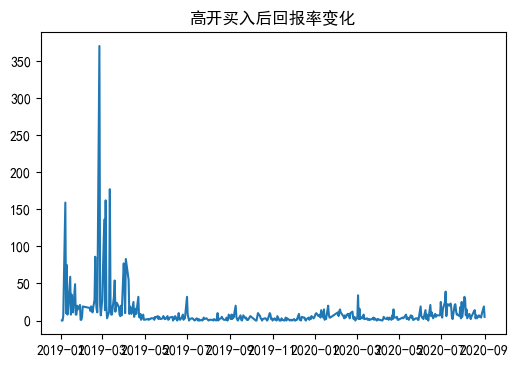

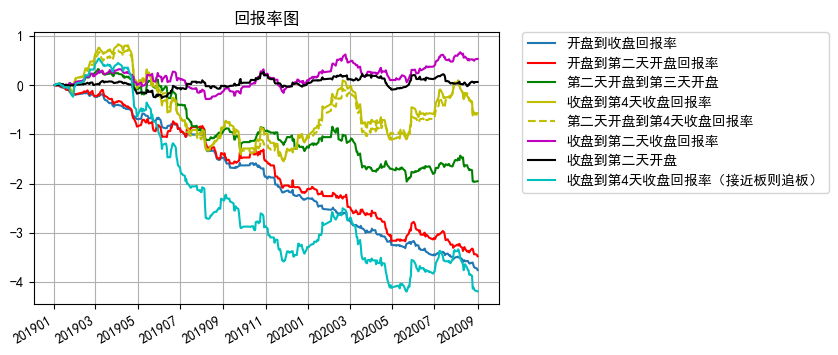

In [205]:
[r1, r2, r3, r4, r5,r6,r7,r8] = calculateProfit(idxQ, '高开买入后回报率变化', off=3)

选股池大小： 1004


C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


-1.3465116902024046 -0.5132403432589201 1.7266676909157477 2.491470407586711 1.7601061455439062 2.491470407586711 0.7758992651489982 1.2531202821459784


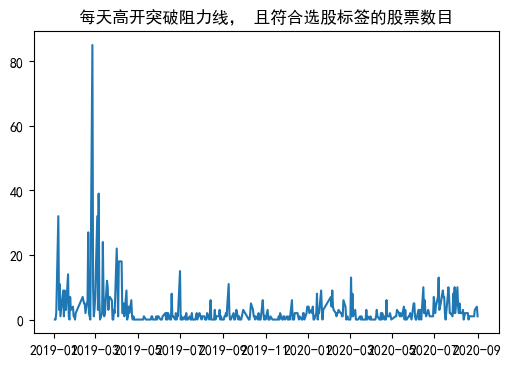

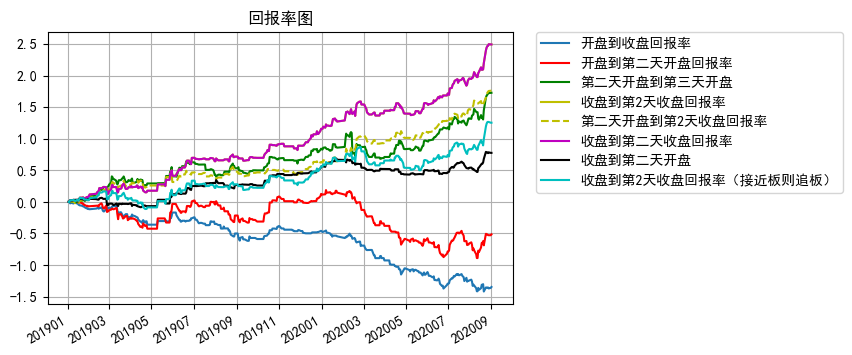

In [206]:
#只选一部分股票
# 流通值>10亿
s = ['SZ002444','SH601216','SZ300395','SH603288','SH603960','SZ300257','SZ002493','SZ002124','SZ002352','SZ300143','SH603737','SH603806','SZ002430','SH603583','SH601012','SH600158','SZ002625','SH603588','SH600316','SZ300433','SH600918','SZ002078','SH600211','SH603298','SH601633','SZ300274','SH603267','SZ300083','SH600399','SZ002250','SZ002294','SZ002706','SH603129','SZ002241','SZ300124','SZ002080','SH601952','SH603039','SH603638','SZ000858','SH600176','SZ002648','SZ000048','SZ002803','SH603338','SH601888','SZ002025','SZ002311','SZ300072','SZ300285','SH601799','SH603877','SH600436','SZ002271','SZ000011','SZ002726','SH601899','SZ002647','SZ002541','SH601666','SZ000568','SH600988','SH603606','SH600893','SZ000733','SH600309','SH603712','SH601919','SH600859','SH600363','SZ000596','SZ000895','SH600426','SH600763','SH603069','SH603345','SZ300068','SH600346','SH600601','SH600298','SH601788','SH600823','SZ300244','SH601689','SH600685','SH603713','SH600323','SZ000830','SH600438','SZ000690','SZ300059','SZ000987','SH601965','SZ002027','SH600660','SZ002030','SZ002475','SZ300496','SZ002163','SZ002157','SZ300116','SH600521','SZ002597','SZ002601','SZ002375','SZ002064','SZ000887','SZ002408','SH600809','SH600305','SZ002389','SZ300777','SH600416','SH600872','SZ300677','SH600966','SH603027','SZ000656','SZ000976','SH600079','SZ000959','SZ002044','SZ300298','SH600835','SH600196','SH601628','SZ002287','SZ002626','SZ300012','SH603444','SH603259','SH603377','SZ300014','SZ000738','SZ300027','SH688002','SZ002747','SH600760','SZ300207','SZ000799','SZ002041','SZ002506','SH603337','SH600195','SZ002709','SH600885','SH600711','SZ002791','SH600388','SZ000157','SH600754','SH603678','SZ002236','SH601233','SH600812','SZ002151','SH600873','SZ300579','SH600236','SZ000786','SH600151','SZ300136','SZ000739','SZ300122','SZ000828','SZ000876','SH601066','SH603816','SH601336','SZ300073','SZ002683','SH600739','SZ002537','SH601168','SZ000878','SZ300751','SZ002415','SZ000869','SH601636','SH600674','SZ300168','SZ300618','SZ002142','SZ002242','SZ300054','SH600011','SZ000951','SH603718','SH600519','SH600779','SZ300408','SH600682','SZ002216','SZ002797','SZ002179','SH600132','SZ300394','SZ300123','SZ002429','SZ000516','SH603369','SH600073','SH600299','SZ000725','SH600886','SZ002714','SH600984','SZ002690','SH600598','SZ300037','SZ300613','SH600415','SH600030','SH600926','SZ000027','SH600862','SZ002028','SZ000807','SH601877','SZ000768','SZ002233','SH600380','SZ002831','SZ300034','SH600223','SZ002032','SZ002594','SZ000800','SZ300685','SZ000582','SZ300572','SZ300639','SH603882','SZ000661','SH601555','SZ002304','SH600409','SZ000728','SH600038','SH600559','SH600795','SZ000513','SZ002414','SZ002001','SZ002698','SH600166','SH603355','SH600115','SH600219','SH600887','SH601611','SZ000783','SZ000902','SZ002081','SZ300502','SZ002736','SZ000937','SZ000090','SH603308','SH601222','SZ002128','SH600645','SH600764','SZ002106','SZ000961','SZ300750','SH601016','SZ002701','SZ002258','SZ300348','SZ002507','SH600406','SZ000581','SH600578','SH601985','SZ002416','SH603866','SZ300523','SH601021','SH600765','SH603601','SZ300142','SZ300601','SZ002595','SH601163','SH601838','SH603868','SH600570','SH601377','SH603883','SZ002511','SH601108','SH600811','SZ002558','SH601100','SZ000789','SH603730','SZ002678','SH601519','SH600398','SZ000883','SZ300315','SH603517','SH600109','SZ000069','SH600633','SZ000012','SZ000778','SH600884','SZ300115','SZ000501','SH600705','SZ000921','SZ000990','SZ300699','SZ300294','SZ002019','SZ002812','SZ300759','SH600372','SZ300251','SH601615','SH600600','SZ002568','SZ002385','SH601878','SH601211','SH601966','SZ002555','SH600850','SZ000028','SZ002353','SZ002126','SZ000566','SH601991','SZ300033','SH600031','SH601018','SH603885','SH600827','SZ300662','SZ000166','SZ002251','SZ002340','SH601881','SH600161','SZ002624','SH600339','SZ000333','SH600881','SH603043','SH600582','SZ002022','SZ000049','SH600737','SZ000062','SZ000060','SH600276','SZ000400','SZ000910','SZ000555','SZ002050','SH600993','SZ000688','SZ000860','SH600958','SZ002100','SH600376','SZ000750','SH601231','SH601801','SZ002959','SZ002007','SH601198','SZ000826','SZ300339','SZ002727','SH603456','SH600500','SZ002675','SH600741','SZ000538','SH600177','SH601949','SZ000686','SH600143','SZ002262','SH600584','SH600482','SZ300146','SZ300024','SZ002239','SH600837','SH603939','SZ002456','SZ000423','SZ300347','SZ000636','SZ002847','SH600787','SZ000703','SH601155','SH600369','SZ000603','SH601727','SZ000598','SH600352','SH600066','SZ002958','SH600783','SH601369','SZ300661','SH600895','SH600803','SZ000338','SH600511','SZ002643','SZ000528','SH603229','SH603899','SH601901','SH600704','SH601099','SH601607','SZ002859','SH603520','SH601139','SZ002773','SH600977','SH600497','SH601618','SH603313','SH600025','SZ000559','SH601106','SZ002926','SH603609','SZ000998','SH601000','SH600456','SH600804','SH600535','SZ300233','SH601333','SZ002705','SH600157','SH600064','SH601669','SZ300418','SH600008','SH600072','SH603686','SH600111','SH600655','SZ002607','SH600549','SZ000066','SZ000630','SZ002152','SZ002230','SZ000030','SH600562','SZ002867','SZ000932','SZ000813','SZ000100','SH601009','SH600037','SZ002508','SH603118','SZ002745','SH601866','SZ002191','SH600056','SH601975','SZ000983','SH603225','SZ002410','SH603589','SZ000963','SH603515','SZ002244','SH601375','SH600717','SH600755','SZ002372','SH601688','SZ300133','SH600648','SZ002202','SH603993','SZ300118','SH600023','SH600027','SH600018','SH600373','SH600970','SH600483','SH603568','SZ300376','SZ000988','SH600089','SZ002608','SH600597','SZ000547','SH600390','SZ300088','SZ000776','SZ000935','SZ300363','SZ000046','SH600216','SZ300226','SH601989','SH600967','SH600435','SZ300015','SZ000685','SZ000960','SH603833','SZ300070','SH603799','SH601228','SZ000050','SH600845','SZ300725','SZ002008','SH600029','SH600062','SH600621','SH600061','SZ300760','SH600643','SH600863','SH601162','SH600839','SH603858','SZ002673','SH600350','SH600649','SH600085','SZ002013','SZ002422','SH600362','SZ002461','SH601567','SH600588','SH600332','SH603233','SH600252','SZ002387','SH600536','SZ000708','SZ002371','SZ002405','SH600383','SZ002841','SZ002252','SH600901','SH600612','SH600848','SZ002038','SH600153','SH600702','SZ300558','SH600642','SZ003816','SH601225','SH601969','SZ300498','SZ300782','SZ002004','SZ002010','SH600420','SH600900','SH600909','SZ000503','SZ002505','SH603218','SH600325','SZ002481','SH600057','SZ002129','SZ002557','SH600871','SZ002155','SH601319','SZ002402','SZ002317','SH600201','SZ300770','SH601699','SH603260','SZ300132','SZ000563','SZ002382','SZ300724','SH600641','SZ002600','SH600266','SH600256','SH603605','SH600446','SZ000089','SH601298','SH601003','SZ000729','SZ300454','SH601916','SH603198','SH600919','SH601608','SH603567','SH600515','SH600098','SZ002939','SZ000627','SH601928','SZ300373','SZ000903','SH600198','SH600563','SH600188','SH600155','SH603429','SZ000519','SH600297','SH600348','SZ000898','SZ002821','SH600720','SH600808','SH600580','SH601326','SZ002223','SH601718','SZ000709','SH603019','SH600036','SH600875','SH603708','SZ002302','SZ000717','SZ002739','SH603258','SZ300253','SZ300474','SH600277','SH601600','SH603699','SH600150','SH688396','SH600623','SZ000967','SZ002695','SH600022','SH601898','SH601098','SH600026','SZ300017','SZ002092','SH600118','SH600879','SH601158','SH603888','SH601601','SH601005','SZ000839','SZ002281','SH600048','SZ300316','SZ000712','SZ002670','SH601238','SZ000796','SZ000078','SH688126','SH600093','SH601128','SZ000623','SH688111','SZ000672','SZ002399','SZ002419','SZ300674','SH601872','SZ002434','SH600206','SZ002146','SZ300296','SH603005','SH601229','SZ002185','SZ300676','SH600604','SZ000540','SH600273','SZ002024','SZ002123','SZ000035','SH600782','SZ000425','SH600307','SZ300009','SZ000629','SH603236','SH600733','SH600208','SH600548','SH600491','SZ002384','SZ002409','SH600489','SH688122','SZ000413','SZ000625','SH600635','SH600271','SH600282','SH600068','SH603881','SZ002183','SZ002099','SH600546','SH600170','SH600291','SZ300026','SH600585','SH600567','SZ000831','SZ000001','SZ000732','SH601998','SH600699','SZ000938','SH601138','SH601390','SH601318','SH601997','SH600466','SH600021','SH600583','SZ300766','SH600330','SH600258','SZ000997','SH600663','SZ000999','SZ000403','SH601958','SZ000402','SZ300595','SH600007','SH603659','SH601857','SH601212','SH600019','SZ002373','SH600529','SZ002237','SZ000009','SH600120','SH600104','SZ002221','SZ002653','SH600864','SH600959','SH600507','SZ002023','SH600728','SH600718','SH600039','SZ002945','SZ300003','SZ000671','SH600572','SH601800','SH601117','SH601992','SZ300748','SZ300113','SZ002465','SH600566','SZ300369','SH600233','SH600340','SZ002938','SZ300529','SZ300413','SZ000426','SH600729','SH600486','SZ000735','SH600748','SH601169','SZ300773','SZ000021','SZ000002','SH600160','SH601668','SH600060','SZ300682','SH600009','SH601818','SZ002368','SZ300010','SH603989','SH600053','SZ002056','SH600320','SH600010','SH600637','SZ002085','SZ000156','SZ000617','SZ002195','SZ300450','SZ002466','SZ300747','SH601006','SH600703','SH600050','SZ002153','SZ300134','SZ002065','SZ002268','SZ002174','SH600547','SH601200','SH603208','SH600015','SH603156','SZ300482','SZ002110','SZ001979','SH603000','SZ002436','SZ000061','SH600528','SZ000016','SH600640','SZ002838','SH600315','SH600917','SZ300383','SH600000','SH601186','SZ300346','SH600100','SH601088','SH601990','SZ002171','SH603707','SZ300476','SZ002217','SZ002036','SH601360','SZ002563','SH603077','SZ002301','SH600016','SH601808','SZ000723','SH603305','SZ000761','SZ300001','SH603228','SZ000818','SH600688','SZ300526','SH600171','SZ300236','SZ300058','SZ300357','SZ000401','SH688009','SH600246','SZ000810','SZ002273','SZ300451','SH601398','SZ002460','SH601766','SH601166','SZ300308','SZ002603','SH600882','SH601939','SH600516','SZ002299','SZ002156','SZ002138','SH600312','SH600820','SH601236','SH601988','SZ300457','SZ000553','SH603986','SH600392','SH603127','SZ300271','SZ300379','SH600028','SZ000063','SZ300188','SH600667','SH600459','SZ002127','SZ002966','SH601816','SH600998','SZ002203','SZ000975','SH600221','SH600487','SH601288','SZ002439','SZ300630','SH600418','SZ000158','SH603658','SZ300144','SZ300166','SZ300463','SH600377','SH601179','SZ300223','SH600776','SZ002602','SZ000970','SH603501','SH601118','SH600260','SZ300326','SH600639','SZ002400','SH601328','SZ300212','SZ002572','SZ300633','SZ002332','SH601933','SH601658','SZ000651','SZ002075','SH688099','SH688012','SH600522','SH600410','SZ002049','SH688008','SZ000415','SZ000088','SZ002498','SZ002916','SH600867','SH688088','SZ300628','SH600498','SH600183','SZ300598','SZ000977','SH688321','SH600004','SZ000877','SZ000034','SH600606','SZ001914','SH600999','SZ002190','SH601717','SZ002396','SH600094','SZ002320','SH600745','SH603160','SZ002463','SH600185','SH600690','SZ000039','SH600267','SH600126','SZ002180','SH688981','SZ002212','SZ002531','SZ000681','SH600460','SZ002500','SH600518','SH600801','SH601258','SZ002074','SH600167','SH601111','SZ000825','SZ002468','SH600317','SH601880','SZ002120','SH600673','SZ002131','SZ300783',]
#连续三年增长率>30%
#s = ['SH603288','SH603960','SH603588','SH603039','SH603638','SZ000858','SZ002803','SZ002271','SZ300354','SZ000568','SH603606','SZ000596','SZ002475','SH600809','SZ300371','SZ300122','SZ300123','SZ300206','SZ300572','SZ300639','SZ000661','SZ002698','SH600449','SZ000961','SZ002511','SH601100','SZ002734','SH600031','SH603088','SZ002757','SH603939','SZ300347','SH600456','SZ300263','SZ002867','SZ000963','SZ300226','SH600845','SH600588','SZ002371','SZ002034','SZ002402','SH601608','SZ002135','SH600217','SZ000425','SZ000632','SH600466','SZ002768','SZ002373','SH600529','SZ300003','SH600340','SZ300529','SZ300413','SZ300260','SZ300482','SZ300383','SZ002301','SZ300451','SZ002015','SZ300035','SH600459','SZ000975','SZ300571','SZ300630','SH603658','SZ002332','SZ300628','SH601717','SZ002463','SH600801','SH600167',]
print('选股池大小：', len(s))
q = [list(tkrs).index(x) for x in s]
idxT = [x in q for x in range(len(tkrs))]
idxQsub = np.array(np.zeros(close_mtx.shape), dtype='bool')
#idxT每天有多少是高开的
for k in range(close_mtx.shape[1]-1):
    idxQsub[:, k+1] = idxQ[:, k+1] & idxT

off = 1
[r1,r2,r3,r4,r5,r6,r7,r8] = calculateProfit(idxQsub, '每天高开突破阻力线， 且符合选股标签的股票数目', detail='no',off=off)


0.0030865031579950207 0.03143554300051555 1.5524433575724674


Text(0.5, 1.0, '策略平均日回报率:0.31%, 平均波动:3.0%, sharpe值:1.55')

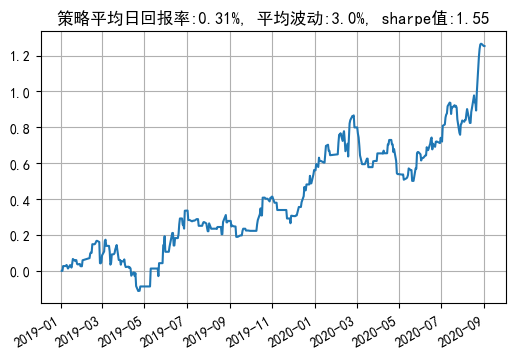

In [208]:
plt.plot(dtes2Label(dtes), np.cumsum(r8))
m = np.mean(r8)
v = np.std(r8)
s = m/v*np.sqrt(250)
print(m,v,s)
plt.grid()
plt.gcf().autofmt_xdate()  # 自动旋转日期标记
plt.title('策略平均日回报率:'+str(np.round(m*1e4)/1e2)+'%, 平均波动:'+str(np.round(v,2)*1e2)+'%, sharpe值:'+str(np.round(s,2)))